In [37]:
import os
import numpy as np
import cv2
import transformations
import scipy.io as sio
import glob
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import sys
import data_generation
import networks
import param
import util
import truncated_vgg
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam

In [38]:
vid_info_list = data_generation.make_vid_info_list('/mnt/data/jarvislam1999/posewarp-cvpr2018/data/train')

In [39]:
vid_info_list[0][1]

array([[ 302.83438486,  274.47024536,   90.83434683,  330.8677063 ],
       [ 319.70578003,  303.67350158,  227.41882565,  266.10512391],
       [ 300.08102417,  301.99597168,   78.83886719,  293.20440674],
       [ 286.60806274,  266.7348938 ,  110.48272705,  333.81942749],
       [ 315.12689209,  303.14028931,  121.45648193,  299.51577759],
       [ 297.52661133,  297.28875732,   90.29504395,  296.92077637],
       [ 346.82519531,  273.38958991,   97.33411068,  323.8873266 ],
       [ 354.43447876,  293.24758911,   88.21963501,  301.28811646]])

In [40]:
len(vid_info_list)

1

In [41]:
bbox=np.array(vid_info_list[0][1])

In [42]:
bbox[0]

array([ 302.83438486,  274.47024536,   90.83434683,  330.8677063 ])

In [43]:
pose=np.array(vid_info_list[0][2])

In [44]:
pose[:,:,0]

array([[ 359.36435331,  317.80599369],
       [ 355.32649842,  356.16561514],
       [ 347.25078864,  382.41167192],
       [ 322.9390564 ,  410.61090088],
       [ 302.83438486,  382.41167192],
       [ 377.53470032,  366.26025237],
       [ 363.4022082 ,  315.78706625],
       [ 342.69271851,  274.47024536],
       [ 358.68118286,  454.33328247],
       [ 345.99520874,  537.0055542 ],
       [ 340.37304688,  585.12249756],
       [ 393.66873169,  450.1137085 ],
       [ 385.28167725,  536.37414551],
       [ 373.97335815,  605.33795166]])

In [45]:
img_01 = Image.open('/mnt/data/jarvislam1999/posewarp-cvpr2018/data/train/frames/Flavia Pennetta in 4k/1.jpg')

In [46]:
img_01 = np.array(img_01, dtype=np.uint8)

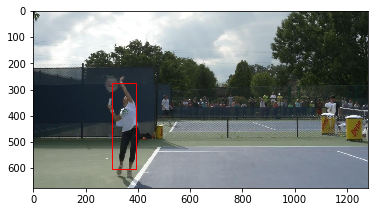

In [47]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img_01)

# Create a Rectangle patch
rect = patches.Rectangle((bbox[0][0],bbox[0][1]),bbox[0][2],bbox[0][3],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [52]:
params = param.get_general_params()

In [53]:
params

{'IMG_HEIGHT': 256,
 'IMG_WIDTH': 256,
 'batch_size': 4,
 'data_dir': '/mnt/data/jarvislam1999/posewarp-cvpr2018/data',
 'limbs': [[0, 1],
  [2, 3],
  [3, 4],
  [5, 6],
  [6, 7],
  [8, 9],
  [9, 10],
  [11, 12],
  [12, 13],
  [2, 5, 8, 11]],
 'max_px_shift': 10,
 'max_rotate_degree': 5,
 'max_sat_factor': 0.05,
 'model_save_dir': '/mnt/data/jarvislam1999/posewarp-cvpr2018/models',
 'model_save_interval': 1000,
 'n_joints': 14,
 'n_limbs': 10,
 'n_training_iter': 200000,
 'obj_scale_factor': 1.14,
 'posemap_downsample': 2,
 'project_dir': '/mnt/data/jarvislam1999/posewarp-cvpr2018',
 'scale_max': 1.05,
 'scale_min': 0.9,
 'sigma_joint': 1.75,
 'test_interval': 500}

In [54]:
# warp generator
img_width = params['IMG_WIDTH']
img_height = params['IMG_HEIGHT']
pose_dn = params['posemap_downsample']
sigma_joint = params['sigma_joint']
n_joints = params['n_joints']
scale_factor = params['obj_scale_factor']
batch_size = params['batch_size']
limbs = params['limbs']
n_limbs = params['n_limbs']

output_generator_warp = []

In [55]:
x_src = np.zeros((batch_size, img_height, img_width, 3))
x_mask_src = np.zeros((batch_size, img_height, img_width, n_limbs + 1))
x_pose_src = np.zeros((batch_size, int(img_height / pose_dn), int(img_width / pose_dn), n_joints))
x_pose_tgt = np.zeros((batch_size, int(img_height / pose_dn), int(img_width / pose_dn), n_joints))
x_trans = np.zeros((batch_size, 2, 3, n_limbs + 1))
x_posevec_src = np.zeros((batch_size, n_joints * 2))
x_posevec_tgt = np.zeros((batch_size, n_joints * 2))
y = np.zeros((batch_size, img_height, img_width, 3))

In [56]:
# 1. choose random video.
vid = np.random.choice(len(vid_info_list), 1)[0]

vid_bbox = vid_info_list[vid][1]
vid_x = vid_info_list[vid][2]
vid_path = vid_info_list[vid][3]

In [57]:
# 2. choose pair of frames
n_frames = vid_x.shape[2]
frames = np.array([0,6])
while abs(frames[0] - frames[1]) / (n_frames * 1.0) <= 0.02:
    frames = np.random.choice(n_frames, 2, replace=False)

In [58]:
frames

array([0, 6])

In [61]:
frames[0]

0

In [67]:
os.path.join(vid_path, str(frames[0] + 1) + '.jpg') == '/mnt/data/jarvislam1999/posewarp-cvpr2018/data/train/frames/Flavia Pennetta in 4k/1.jpg'

True

In [106]:
I0, joints0, scale0, pos0 = data_generation.read_frame(vid_path, frames[0], vid_bbox, vid_x)
I1, joints1, scale1, pos1 = data_generation.read_frame(vid_path, frames[1], vid_bbox, vid_x)

In [107]:
I0

array([[[ 39,  54,  46],
        [ 22,  37,  29],
        [ 35,  50,  42],
        ..., 
        [ 28,  43,  35],
        [ 27,  42,  34],
        [ 26,  41,  33]],

       [[ 35,  50,  42],
        [ 26,  41,  33],
        [ 40,  55,  47],
        ..., 
        [ 27,  42,  34],
        [ 25,  40,  32],
        [ 24,  39,  31]],

       [[ 36,  51,  43],
        [ 31,  46,  38],
        [ 43,  56,  48],
        ..., 
        [ 25,  40,  32],
        [ 25,  38,  30],
        [ 24,  37,  29]],

       ..., 
       [[125, 144, 135],
        [125, 144, 135],
        [126, 145, 136],
        ..., 
        [149, 126, 111],
        [149, 126, 111],
        [149, 126, 111]],

       [[126, 145, 136],
        [126, 145, 136],
        [127, 146, 137],
        ..., 
        [149, 126, 111],
        [149, 126, 111],
        [149, 126, 111]],

       [[127, 146, 137],
        [127, 146, 137],
        [128, 147, 138],
        ..., 
        [149, 126, 111],
        [149, 126, 111],
        [149, 126,

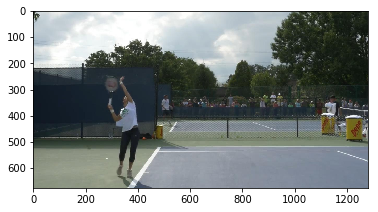

In [101]:
plt.imshow(cv2.cvtColor(I0, cv2.COLOR_BGR2RGB))
plt.show()

In [108]:
do_augment = True
if scale0 > scale1:
    scale = scale_factor / scale0
else:
    scale = scale_factor / scale1

pos = (pos0 + pos1) / 2.0
#print(I0)
I0, joints0 = data_generation.center_and_scale_image(I0, img_width, img_height, pos, scale, joints0)
I1, joints1 = data_generation.center_and_scale_image(I1, img_width, img_height, pos, scale, joints1)
#print(I0)
I0 = (I0 / 255.0 - 0.5) * 2.0
I1 = (I1 / 255.0 - 0.5) * 2.0
#print(I0)
if do_augment:
    rflip, rscale, rshift, rdegree, rsat = data_generation.rand_augmentations(params)
    I0, joints0 = data_generation.augment(I0, joints0, rflip, rscale, rshift, rdegree, rsat, img_height, img_width)
    I1, joints1 = data_generation.augment(I1, joints1, rflip, rscale, rshift, rdegree, rsat, img_height, img_width)
print(I0)
posemap0 = data_generation.make_joint_heatmaps(img_height, img_width, joints0, sigma_joint, pose_dn)
posemap1 = data_generation.make_joint_heatmaps(img_height, img_width, joints1, sigma_joint, pose_dn)

src_limb_masks = data_generation.make_limb_masks(limbs, joints0, img_width, img_height)
src_bg_mask = np.expand_dims(1.0 - np.amax(src_limb_masks, axis=2), 2)
src_masks = np.log(np.concatenate((src_bg_mask, src_limb_masks), axis=2) + 1e-10)


[[[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 ..., 
 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]]


In [91]:
x_src[0, :, :, :] = I0
x_pose_src[0, :, :, :] = posemap0
x_pose_tgt[0, :, :, :] = posemap1
x_mask_src[0, :, :, :] = src_masks
x_trans[0, :, :, 0] = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
x_trans[0, :, :, 1:] = data_generation.get_limb_transforms(limbs, joints0, joints1)

x_posevec_src[0, :] = joints0.flatten()
x_posevec_tgt[0, :] = joints1.flatten()

y[0, :, :, :] = I1

In [92]:
out = [x_src, x_pose_src, x_pose_tgt, x_mask_src, x_trans]

In [93]:
output_generator_warp.append((out,y))

In [94]:
output_generator_warp

[([array([[[[ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            ..., 
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.]],
   
           [[ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            ..., 
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.]],
   
           [[ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            ..., 
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.]],
   
           ..., 
           [[ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            ..., 
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.]],
   
           [[ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            ..., 
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.]],
  